In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NLP/lab_3")

## Lab 3. Clasificarea textelor utilizând vectorizarea Bag-of-Words

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 1. Bag-of-Words

Am văzut în laboratorul trecut cum putem folosi diverse tehnici pentru a reduce un text la o listă de cuvinte (tokens). Am văzut cum putem elimina cuvintele care au o încărcătura semantică redusă (stopwords) și cum putem normaliza tokenii, aducandu-i la o forma unica pentru inlfexiuni diferite ale acestora (lematizare, stemming).

Pentru a antrena un model de Machine Learning avem nevoie să mai facem cațiva pași. Aceste reprezentari determinate anterior (liste de tokens) trebuie traduse în reprezentări numerice vectoriale (fiecarui text îi vom asocia un vector, iar toți vectorii corespunzători textelor vor avea aceeași dimensiune).

O astfel de metoda este reprezentarea textelor folosind tehnica Bag-of-Words. Aceasta metodă pornește de la un vocabular de cuvinte, un șir $[w_1, w_2, \ldots, w_n]$, unde $w_i$ reprezintă un cuvânt din vocabular. Vocabularul poate fi stabilit de la început sau determinat pe baza listelor preprocesate de tokeni (putem defini vocabularul ca cei mai frecventi $n$ tokens din aceste liste).

Un text (lista de tokens) poate fi acum transformat intr-un vector de dimensiune $n$: $(a_1, \ldots, a_n)$ unde $a_i=1$ daca cuvântul $w_i$ apare cel pușin o dată în text, respectiv $a_i=0$ altfel. Aceasta reprezentare o mai numim și Bag-of-Words binar.

O altfel de reprezentare asemanatoare poate fi bazata pe frecvente, unde $a_i$ reprezintă numărul de apariții ale cuvantului $w_i$ în text.

In [65]:
# exemplu texte (procesate ca liste de tokens)
texts = [
    ["love", "fun", "fun", "play", "happy", "sad"],
    ["love", "happy", "love", "love", "tears"],
    ["sad", "tears", "tears"],
]

# exemplu vocabular
vocab = ["love", "fun", "tears", "sad", "happy"]

In [66]:
# reprezentare BoW binar
repr_bin = [
    [1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1],
    [0, 0, 1, 1, 0],
]

In [67]:
# reprezentare BoW pe baza de frecvente
repr_fr = [
    [1, 2, 0, 1, 1],
    [3, 0, 1, 0, 1],
    [0, 0, 2, 1, 0],
]

Această logică poate fi implementată ușor, dar aceasta poate fi regasită (împreună cu alte detalii interesante) în clasa [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) din scikit-learn.

Într-un obiect de acest tip putem încorpora și logica de preprocesare + tokenizare a textelor.

In [68]:
texts = [
    "Love fun fun Play Happy sad",
    "love happy Love love tears",
    "sad Tears tears",
]

Implementăm o preprocesare rudimentară a acestor texte, transformăm toate majusculele în litere mici, iar pentru tokenizare dăm split dupa spațiu. În cazul în care lucrați cu texte mai complexe, în acești pași puteți include ce am discutat în laboratorul anterior (eliminare de punctuatie, tokenizare, eliminare de stopwords, lematizare, stemming etc.).

In [69]:
def dummy_preprocess(text):
    return text.lower()

def dummy_tokenize(text):
    return text.split(" ")

test_preprocess = dummy_preprocess(texts[0])
test_tokens = dummy_tokenize(test_preprocess)
print(test_tokens)

['love', 'fun', 'fun', 'play', 'happy', 'sad']


In [70]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess,  # metoda de preprocesare a textelor
    tokenizer=dummy_tokenize,       # metoda de tokenizare
    token_pattern=None,             # nu avem nevoie de acest argument intrucat avem propria metoda de tokenizare
    max_features=5,                 # dimensiunea maximă a vocabularului care va fi determinat
    binary=True,                    # BoW binar
)

# metoda `fit` este folosita in acest caz pentru a determina vocabularul
# (pastrand cei mai frecventi `max_features` tokens din textele procesate)
cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 1 1 0]
 [0 1 1 0 1]
 [0 0 0 1 1]]


In [71]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    binary=False,                   # BoW bazat pe frecvente
)
 
cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[2 1 1 1 0]
 [0 1 3 0 1]
 [0 0 0 1 2]]


O alternativă a acestor reprezentări este numărarea n-gramelor.

Sa luam spre exemplu fraza "I am not happy". Metoda de mai devreme ne reda reprezentarea acestei fraza ca o multime de cuvinte (indiferent de ordinea lor). Astfel, această reprezentare indica prezența cuvantului "happy", ceea ce ar face un model să interpreteze textul într-un cadru pozitiv. Dar vedem clar că nu este aceasta situația. Dacă în loc de tokeni simpli (unigrame) am număra secvențe de cțte 2 tokeni consecutivi (bigrame), am putea identifica prezența bigramei ("not", "happy") care intuim că nu ar avea ce căuta într-un text cu sentiment pozitiv.

In [72]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    ngram_range=(2, 2),                   # construim un vocabular de bigrame
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun fun', 'fun play', 'happy love', 'happy sad', 'love fun']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]]


### 2. Feature Scaling (normalizarea datelor)

#### Standard Scaling

Având determinați vectorii de features se pune urmatoarea problemă: știind că un feature reprezintă frecventa unui cuvânt din vocabular în texte (în vectorizarea BoW), iar pentru anumite cuvinte în mod natural această frecvență este mai mare, faptul că anumite feature-uri au valoare absolută mai mare decât alta poate influența diverși algoritmi de ML să trateze acele feature-uri cu mai multa importanță (ceea ce de multe ori nu este corect).

Prin Standard Scaling presupunem că fiecare feature corespunde câte unei variabile aleatoare distribuita normal. Putem deci estima pentru fiecare astfel de variabilă media si deviatia standard, apoi prin procesul de standardizare putem reduce valorile feature-ului corespunzător la o distribuție normală de medie $0$ și varianță $1$.

In [73]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)
 
# clasa folosita pentru standardizare
scaler = preprocessing.StandardScaler()

# calculam media si deviatia standard pentru feature vectorii de antrenare
scaler.fit(x_train)

print('media =', scaler.mean_)  
print('std =', scaler.scale_) 

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
# (folosim media si std determinate din train, datele de test nu sunt folosite pentru a determina hiperparametrii)
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)     

media = [1.         0.         0.33333333]
std = [0.81649658 0.81649658 1.24721913]
[[ 0.         -1.22474487  1.33630621]
 [ 1.22474487  0.         -0.26726124]
 [-1.22474487  1.22474487 -1.06904497]]
[[-2.44948974  1.22474487 -0.26726124]]


#### Normalizare L1 si L2

Acest mod de normalizare este mai simplu întrucât nu mai necesită determinarea unor parametri. Fiecare vector de features este împărțit prin norma sa (L1 sau L2), obținând astfel ca toți vectorii corespunzătoari textelor să aibă norma 1.

$$x{\_}scaled_1 = \frac{X}{\mid\mid X \mid\mid_1}, \mid\mid X \mid\mid_1 = \sum_{i=1}^{n}\mid x_i \mid $$
$$x{\_}scaled_2 = \frac{X}{\mid\mid X \mid\mid_2}, \mid\mid X \mid\mid_2 = \sqrt{\sum_{i=1}^{n} x_i ^ 2 }$$

In [74]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)

# clasa folosita pentru normalizare
scaler = preprocessing.Normalizer(norm='l1') 
# scaler = preprocessing.Normalizer(norm='l2')

scaler.fit(x_train)

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)  

[[ 0.25 -0.25  0.5 ]
 [ 1.    0.    0.  ]
 [ 0.    0.5  -0.5 ]]
[[-0.5  0.5  0. ]]


### 3. Tf-Idf

O altă metodă de normalizare a feature-urilor pentru reprezentarea Bag-of-Words este **Tf-Idf**.

**Term Frequency (TF)** numară pentru un token și un document de câte ori apare tokenul respectiv în document.

O varianta de calcul pentru un token $t$ și un document $d$ ar fi: $\textrm{tf}(t, d) = log(1 + \textrm{frecv}(t, d))$.

**Inverse Document Frequency (IDF)** iluestrează cât de comun sau rar este un cuvânt într-un întreg corpus (mulțime de texte). Astfel, cu cât această valoare se apropie de $0$ tokenul respectiv este mai comun.

Pentru un token $t$ și o mulțime de $N$ documente $D$, putem calcula IDF astfel: $\textrm{idf}(t, D) = \log(\frac{N}{|\{d \in D: t \textrm{ apare in } d\}|})$.

**TF-IDF** combina cele doua formule:
$$\textrm{tfidf}(t, d, D) = \textrm{tf}(t, d) \cdot \textrm{idf}(t, D)$$.

Mai multe informatii [aici](https://ro.wikipedia.org/wiki/Tf%E2%80%93idf).

In [75]:
# exemplu TfidfVectorizer

cv = TfidfVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[0.83513325 0.31757018 0.31757018 0.31757018 0.        ]
 [0.         0.30151134 0.90453403 0.         0.30151134]
 [0.         0.         0.         0.4472136  0.89442719]]


### 4. Clasificare folosind Scikit-Learn

In [95]:
# generam o problema "dummy" de clasificare:
# - 1000 de feature vectori de dimensiune 10 (din care doar 5 sunt relevanti pentru clasificare)
# - fiecarui vector ii este asociat un label (0, 1 sau 2)
X, y = make_classification(
    n_samples=1000, n_classes=3, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(type(y_train))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

<class 'numpy.ndarray'>
(800, 10) (800,)
(200, 10) (200,)


Vom folosi pentru clasificare un decision tree (mai multe detalii [aici](https://en.wikipedia.org/wiki/Decision_tree_learning))

In [77]:
# initializam un astfel de algoritm cu anumiti hiperparametri
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5)

# antrenam folosind datele de train
clf.fit(X_train, y_train)

# folosim modelul pentru a prezice labelurile de test
y_test_predict = clf.predict(X_test)

### 5. Metrici

Avem la dispoziție mai multe metrici pe care le putem folosi pentru a determina performanța unui astfel de model. Să pornim mai întâi de la cazul simplu al unei probleme de clasificare binară (0/1).

In [79]:
y_true    = [0, 0, 0, 1, 1, 1, 1]
y_predict = [0, 1, 0, 0, 1, 1, 0]

Definim:
 * TP (true positive): numărul de labeluri 1 prezise corect
 * FP (false positive): numărul de labeluri 1 prezise incorect
 * TN (true negative): numărul de labeluri 0 prezise corect
 * FN (false negative): numărul de labeluri 0 prezise incorect
 
Acuratețea se calculează după formula:
$$\frac{TP+TN}{TP+FP+TN+FN}$$

Cu alte cuvinte, numărul total de labeluri prezise corect din totalul de predicții.

In [80]:
print("Accuracy:", metrics.accuracy_score(y_true, y_predict))

Accuracy: 0.5714285714285714


Acuratețea nu este mereu cea mai bună metrică de urmărit atunci când vrem să apreciem cât de bun este un model. De exemplu, in cazul unui dataset dezechilibrat (imbalanced), în care $99\%$ din obiecte au labelul $0$ și doar $1\%$ au labelul $1$, un clasificator care prezice doar labelul $0$ pentru toate exemplele ar avea acuratete $99\%$! Dacă problema ar fi fost detectarea de spam, sau detectarea simptomelor asociate unui anumit tip de cancer, un astfel de model nu ar fi considerat unul performant.

Introducem astfel alte cateva metrici:
 * P (precision): $\frac{TP}{TP+FP}$ (dintre toate predictiile 1, cate sunt corecte?)
 * R (recall): $\frac{TP}{TP+FN}$ (dintre toate obiectele din clasa 1, cate am reusit sa prezicem corect?)
 * F1: $\frac{2PR}{P+R}$ (media armonica intre precision si recall)

 Un clip explicativ aici: https://youtu.be/qWfzIYCvBqo

In [81]:
print("Precision:", metrics.precision_score(y_true, y_predict))
print("Recall:", metrics.recall_score(y_true, y_predict))
print("F1:", metrics.f1_score(y_true, y_predict))

Precision: 0.6666666666666666
Recall: 0.5
F1: 0.5714285714285715


În cazul problemelor de clasificare de tip multi-class (mai mult de 2 clase), acuratețea păstrează același sens de "câte predicții sunt corecte din totalul predicțiilor".

Precision, Recall și F1 se calculează într-o manieră *one-vs-rest*. Astfel, fixând o anumită clasă, transformăm labelurile în $1$ dacă labelul original corespunde clasei fixate și $0$ altfel. Putem acum calcula aceste metrici în cazul binar. Rezultatele obținute pentru fiecare astfel de fixare vor fi acumulate și rezultatul final este media acestora (calculată ca medie aritmetică - macro, sau ca medie ponderată - weighted, în care ponderile sunt date de numărul de exemple din clasa respectivă).

In [82]:
# calculam acuratete si F1 pentru clasificarea de mai devreme
print("Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test, y_test_predict, average="weighted"))

Accuracy: 0.7
F1 (macro): 0.6935607271177741
F1 (weighted): 0.6932996310177518


In [83]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        68
           1       0.67      0.86      0.75        65
           2       0.65      0.51      0.57        67

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



O vizualizare utilă este și **matricea de confuzie**, în care numărăm $A[i][j]$ câte obiecte din clasa $i$ au fost prezise ca facând parte din clasa $j$.

In [22]:
cm = metrics.confusion_matrix(y_test, y_test_predict)
print(cm)

[[50  7 11]
 [ 2 56  7]
 [12 21 34]]


<AxesSubplot:>

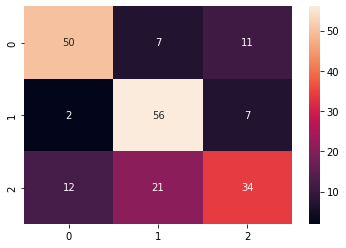

In [23]:
sns.heatmap(cm, annot=True)

### 6. Importanța feature-urilor

Intuitiv, anumite feature-uri sunt mai importante decât altele când vine vorba de clasificare. De exemplu, prezența cuvântului "happy" sau "sad" ne poate oferi informații despre sentimentul unui text, pe cand cuvantul "car", nu.

Feature: 0, Score: 0.11837956006934854
Feature: 1, Score: 0.0
Feature: 2, Score: 0.4172424563910119
Feature: 3, Score: 0.039030730202152863
Feature: 4, Score: 0.0
Feature: 5, Score: 0.21084131505634365
Feature: 6, Score: 0.0
Feature: 7, Score: 0.04661388817258808
Feature: 8, Score: 0.06021961536405184
Feature: 9, Score: 0.10767243474450318


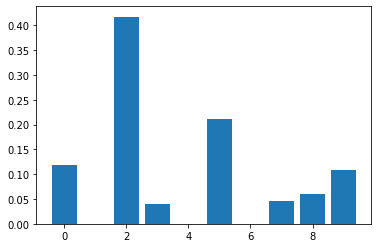

In [24]:
# pentru decision tree avem urmatoare metoda pentru a extrage aceasta importanta
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

Pentru alte modele există diverse alte moduri de a extrage importanța feature-urilor (ex. logistic regression, SVM linear, Random Forest etc.), însă pentru altele este mult mai complicat sau chiar imposibil (ex. SVM cu kernel RBF).

# TASK:

### Deadline: 26 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/ZNPxW6Twm52T94HcA

Vom folosi urmatorul dataset: https://www.kaggle.com/rmisra/news-category-dataset (headline-uri de stiri etichetate conform unei liste de categorii).

In [4]:
import string
import json

! python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
analyzer = CountVectorizer().build_analyzer()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')

import pandas as pd

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-17 18:37:39.804642: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 18:37:39.804772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 18:37:39.804802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. (opțional) Întrucît setul de date conține multe categorii, puteți păstra doar exemple din 4-5 clase (selectate de voi) și să rezolvați problema de clasificare doar pentru aceste exemple.

In [35]:
texts = []
categories = []
number_of_categories = 4
category_types = []

with open("News_Category_Dataset_v3.json", "r") as f:
  line = f.readline()
  while (not (line is None or line == '')):
    try:
        text = json.loads(line)  # apare scris gresit cel putin un json: "category" : COMEDY""
    except:
      line = f.readline()
      continue
    
    if number_of_categories > 0:  
      if text['category'] not in category_types:   # adaugam o categorie noua
        category_types.append(text['category'])
        number_of_categories -= 1
      texts.append(text['headline'])
      categories.append(text['category'])
    else: # avem deja 4 categorii
      if text['category'] in category_types:  # adaugam doar daca apartine de una din cele 4 categorii
        texts.append(text['headline'])
        categories.append(text['category'])
    line = f.readline()

print(categories)
texts

['U.S. NEWS', 'U.S. NEWS', 'COMEDY', 'PARENTING', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'PARENTING', 'U.S. NEWS', 'U.S. NEWS', 'U.S. NEWS', 'PARENTING', 'WORLD NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS', 'U.S. NEWS', 'WORLD NEWS', 'WORLD NEWS', 'WORLD NEWS', 'U.S. NEWS

['Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
 'American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video',
 '23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)',
 'The Funniest Tweets From Parents This Week (Sept. 17-23)',
 'Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer',
 'Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police',
 'Reporter Gets Adorable Surprise From Her Boyfriend While Live On TV',
 'Puerto Ricans Desperate For Water After Hurricane Fiona’s Rampage',
 "Biden At UN To Call Russian War An Affront To Body's Charter",
 'World Cup Captains Want To Wear Rainbow Armbands In Qatar',
 "Man Sets Himself On Fire In Apparent Protest Of Funeral For Japan's Abe",
 'Fiona Threatens To Become Category 4 Storm Headed To Bermuda',
 'Virginia Thomas Agrees To Interview With Jan. 6 Panel',
 'Russian Cosmonaut Valery Polyakov Who Broke Record With 437-Day

2. Încercați mai multe metode de preprocesare și tokenizare a textelor pentru a obține reprezentări de tip Bag-of-Words (ștergeti/nu ștergeti stop words, lematizați sau aplicați stemming, păstrați sau eliminați punctuația, normalizați folosind standardizare, L1, L2 sau Tf-Idf). Implementați **3** astfel de combinații.

In [36]:
# Combinatie 1:
# - lowercase
# - stergere punctuatie
# - stergere stop words
# - standardizare
# - normalizare L1

def preprocess(text):    # eliminarea punctuatiei + lowercase
  return text.lower().translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    return text.split(" ")

# preprocesare + tokenizare
cv = CountVectorizer(
    preprocessor=preprocess, 
    tokenizer=tokenize, 
    stop_words="english",        # elimin stopwords
    token_pattern=None,            
    max_features=10,     
    binary=False,                # BoW bazat pe frecvente
)
 
cv.fit(texts)
features = cv.transform(texts)
matrix = features.toarray()

# scalare 
scaler = preprocessing.StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

# normalizare
normalizer = preprocessing.Normalizer(norm='l1') 
normalizer.fit(scaled_matrix)
combination_1_matrix = normalizer.transform(scaled_matrix)
combination_1_vocabulary = list(cv.vocabulary_.keys())

results = pd.DataFrame(combination_1_matrix, columns=combination_1_vocabulary)
results

,video,parents,baby,new,trump,day,mom,kids,,donald
0,-0.081011,-0.086835,-0.086366,-0.096744,-0.128597,-0.079503,-0.099053,-0.092961,-0.119571,-0.129359
1,-0.027684,-0.029674,-0.029514,-0.033061,-0.043946,-0.027169,-0.033850,-0.031768,-0.040861,0.702472
2,-0.081011,-0.086835,-0.086366,-0.096744,-0.128597,-0.079503,-0.099053,-0.092961,-0.119571,-0.129359
3,-0.021507,-0.023053,-0.022928,-0.025684,-0.034140,-0.021106,-0.026296,0.759200,-0.031744,-0.034342
4,-0.081011,-0.086835,-0.086366,-0.096744,-0.128597,-0.079503,-0.099053,-0.092961,-0.119571,-0.129359
...,...,...,...,...,...,...,...,...,...,...
18862,0.768143,-0.021908,-0.021790,-0.024408,-0.032445,-0.020058,-0.024991,-0.023454,-0.030167,-0.032637
18863,-0.081011,-0.086835,-0.086366,-0.096744,-0.128597,-0.079503,-0.099053,-0.092961,-0.119571,-0.129359
18864,0.516925,-0.014743,-0.014664,-0.016426,-0.021834,-0.013498,-0.016818,-0.015783,-0.020301,0.349009
18865,-0.027684,-0.029674,-0.029514,-0.033061,-0.043946,-0.027169,-0.033850,-0.031768,-0.040861,0.702472


In [37]:
# Combinatie 2:
# - lowercase
# - elimin punctuatie
# - lematizez
# - nu sterg stop Words
# - standardizare
# - normalizare L2

def preprocess(text):    # lowercase + stergere punctuatie
  return text.lower().translate(str.maketrans('', '', string.punctuation))

def lemmatized_tokenizer(text):      #lematizez
    return [word.lemma_ for word in nlp(text)]

cv = CountVectorizer(
    preprocessor=preprocess, 
    tokenizer=lemmatized_tokenizer, 
    token_pattern=None,
    max_features=10,              
    binary=False,                # BoW bazat pe frecvente
)
 
cv.fit(texts)
features = cv.transform(texts)
matrix = features.toarray()

# scalare 
scaler = preprocessing.StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

# normalizare
normalizer = preprocessing.Normalizer(norm='l2') 
normalizer.fit(scaled_matrix)
combination_2_matrix = normalizer.transform(scaled_matrix)
combination_2_vocabulary = list(cv.vocabulary_.keys())

results = pd.DataFrame(combination_2_matrix, columns=combination_2_vocabulary)
results

,for,on,of,the,and,be,in,to,with,a
0,-0.136197,-0.117683,-0.150277,0.903891,-0.140263,-0.147494,-0.102419,-0.185965,-0.177668,-0.099661
1,-0.090080,-0.077835,-0.099392,0.597827,-0.092769,-0.097551,0.753092,-0.122996,-0.117508,-0.065915
2,-0.099209,0.706317,-0.109466,-0.093678,-0.102171,0.554560,-0.074605,0.353490,-0.129418,-0.072595
3,-0.215229,-0.185973,-0.237480,-0.203230,-0.221655,-0.233082,-0.161851,0.766880,-0.280766,-0.157492
4,-0.111744,-0.096554,-0.123296,-0.105514,-0.115080,-0.121013,0.934213,-0.152576,-0.145770,-0.081767
...,...,...,...,...,...,...,...,...,...,...
18862,-0.128357,0.913832,-0.141627,-0.121201,-0.132189,-0.139004,-0.096523,-0.175260,-0.167441,-0.093924
18863,-0.094885,-0.081987,-0.104695,-0.089595,-0.097718,0.530389,-0.071353,0.805725,-0.123778,-0.069431
18864,-0.094885,-0.081987,-0.104695,-0.089595,-0.097718,0.530389,-0.071353,0.805725,-0.123778,-0.069431
18865,-0.304912,-0.263464,-0.336433,-0.287912,-0.314014,-0.330203,-0.229291,-0.416330,-0.397756,-0.223116


In [38]:
# Combinatie 3:
# - lowercase
# - pastrez punctuatie
# - aplic stemming
# - sterg stop words
# - normalizare Tf-Idf

def preprocess(text):    # lowercase
  return text.lower()

def stemming_tokenizer_without_stop_words(text):    #stemming + eliminare stop words
    return [stemmer.stem(w) for w in analyzer(text) if w not in english_stop_words]

cv = TfidfVectorizer(
    preprocessor=preprocess, 
    tokenizer=stemming_tokenizer_without_stop_words, 
    token_pattern=None,
    max_features=10,              
    binary=False,                # BoW bazat pe frecvente
)
 
cv.fit(texts)
features = cv.transform(texts)
combination_3_matrix = features.toarray()
combination_3_vocabulary = list(cv.vocabulary_.keys())

results = pd.DataFrame(combination_3_matrix, columns=combination_3_vocabulary)
results

,video,parent,day,babi,new,mom,year,trump,kid,donald
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


3. Împărțiți setul de date în 80% train, 20% test, iar pentru fiecare metodă de preprocesare antrenați un model ales de voi (diferit de Decision Tree) pe datele de train.

In [82]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [42]:
def antrenare(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2)
  rf = RandomForestClassifier(n_estimators=1000, random_state=7)
  rf.fit(X_train, y_train)
  return rf, X_test, y_test

combination_1_rf, combination_1_X_test, combination_1_y_test = antrenare(combination_1_matrix, categories)
combination_2_rf, combination_2_X_test, combination_2_y_test = antrenare(combination_2_matrix, categories)
combination_3_rf, combination_3_X_test, combination_3_y_test = antrenare(combination_3_matrix, categories)

4. Evaluati modelul pe datele de test, determinând acuratețe, precizie, recall, f1, și stabiliți care metodă de procesare a textelor a adus rezultate mai bune.

In [49]:
def evaluare_model(X, y):
  rf, X_test, y_test = antrenare(X, y)
  y_predict = rf.predict(X_test)

  print("Accuracy:", metrics.accuracy_score(y_test, y_predict))
  print("Precision:", metrics.precision_score(y_test, y_predict, average='micro'))
  print("Recall:", metrics.recall_score(y_test, y_predict, average='micro'))
  print("F1 (macro):", metrics.f1_score(y_test, y_predict, average="macro"))
  print("F1 (weighted):", metrics.f1_score(y_test, y_predict, average="weighted"))

  return rf

# Accuracy: 0.5135135135135135
# Precision: 0.5135135135135135
# Recall: 0.5135135135135135
# F1 (macro): 0.26167265610479234
# F1 (weighted): 0.4085185762048913
rf_1 = evaluare_model(combination_1_matrix, categories)

# Accuracy: 0.47509273979862215
# Precision: 0.47509273979862215
# Recall: 0.47509273979862215
# F1 (macro): 0.29304249793643694
# F1 (weighted): 0.40605519473254365
rf_2 = evaluare_model(combination_2_matrix, categories)

# Accuracy: 0.5468998410174881
# Precision: 0.5468998410174881
# Recall: 0.5468998410174881
# F1 (macro): 0.2974302254228143
# F1 (weighted): 0.45626554031307237
rf_3 = evaluare_model(combination_3_matrix, categories)

# Ultima metoda de procesare a datelor a adus rezultate cele mai bune

Accuracy: 0.5135135135135135
Precision: 0.5135135135135135
Recall: 0.5135135135135135
F1 (macro): 0.26167265610479234
F1 (weighted): 0.4085185762048913
Accuracy: 0.47509273979862215
Precision: 0.47509273979862215
Recall: 0.47509273979862215
F1 (macro): 0.29304249793643694
F1 (weighted): 0.40605519473254365
Accuracy: 0.5468998410174881
Precision: 0.5468998410174881
Recall: 0.5468998410174881
F1 (macro): 0.2974302254228143
F1 (weighted): 0.45626554031307237


5. Determinați pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).

Feature: 0, Score: 0.09612985571671331
Feature: 1, Score: 0.010085734582303729
Feature: 2, Score: 0.08605656134965396
Feature: 3, Score: 0.1832780813918877
Feature: 4, Score: 0.10803938357349432
Feature: 5, Score: 0.013786782574723383
Feature: 6, Score: 0.1641976466832638
Feature: 7, Score: 0.22670867341979017
Feature: 8, Score: 0.0923580500366656
Feature: 9, Score: 0.01935923067150412


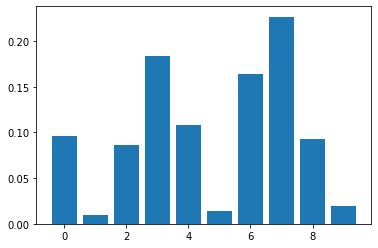

In [50]:
importance = rf_3.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

6. Folosind această metodă de procesare a textelor, antrenați alte doua modele diferite la alegere și comparati performanța cu modelul original.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(combination_3_matrix, np.array(categories), test_size=0.2)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_predict_knn))
print("Precision:", metrics.precision_score(y_test, y_predict_knn, average='micro'))
print("Recall:", metrics.recall_score(y_test, y_predict_knn, average='micro'))
print("F1 (macro):", metrics.f1_score(y_test, y_predict_knn, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test, y_predict_knn, average="weighted"))
# Accuracy: 0.5384207737148914
# Precision: 0.5384207737148914
# Recall: 0.5384207737148914
# F1 (macro): 0.2792205623388231
# F1 (weighted): 0.44208341693240855

# MLP
mlp = MLPClassifier(max_iter=300, activation = 'relu', solver='adam', random_state=1)
mlp.fit(X_train, y_train)
y_predict_mlp = mlp.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_predict_mlp))
print("Precision:", metrics.precision_score(y_test, y_predict_mlp, average='micro'))
print("Recall:", metrics.recall_score(y_test, y_predict_mlp, average='micro'))
print("F1 (macro):", metrics.f1_score(y_test, y_predict_mlp, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test, y_predict_mlp, average="weighted"))
# Accuracy: 0.5476947535771065
# Precision: 0.5476947535771065
# Recall: 0.5476947535771065
# F1 (macro): 0.2983508555192691
# F1 (weighted): 0.45743019695152287

# Acuratetea acestor doua metode este asemanatoate (+/-) cu acuratetea clasificarii cu RandomForest. In cazul 
# acestei ultime rulari, KNN a fost un putin mai slab (0.5384) si MLP putin mai bun 0.5476, comparativ cu 0.5468 .

Accuracy: 0.5384207737148914
Precision: 0.5384207737148914
Recall: 0.5384207737148914
F1 (macro): 0.2792205623388231
F1 (weighted): 0.44208341693240855
Accuracy: 0.5476947535771065
Precision: 0.5476947535771065
Recall: 0.5476947535771065
F1 (macro): 0.2983508555192691
F1 (weighted): 0.45743019695152287


7. Pentru cel mai bun model afisați metricile la nivel de clasă (classification report) și matricea de confuzie.

              precision    recall  f1-score   support

      COMEDY       0.77      0.31      0.45      1069
   PARENTING       0.52      0.96      0.68      1777
   U.S. NEWS       1.00      0.00      0.00       282
  WORLD NEWS       0.31      0.04      0.07       646

    accuracy                           0.55      3774
   macro avg       0.65      0.33      0.30      3774
weighted avg       0.59      0.55      0.46      3774



<Axes: >

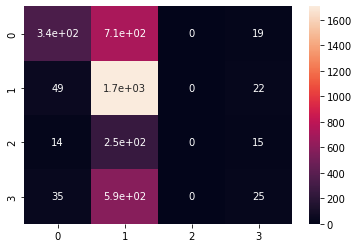

In [80]:
# classification report
print(metrics.classification_report(y_test, y_predict_mlp, zero_division=1))

#matricea de confuzie
cm = metrics.confusion_matrix(y_test, y_predict_mlp)
sns.heatmap(cm, annot=True)